# Case | Song recommendation

This notebook creates a pipeline to get song recommendation based on songs in the Billboard Hot 100 list. A user can choose a song title and - if it is present in the Hot 100 list - is recommended a similar song based on a model of song clustering, or a song with this title is added to the cluster model.

# 1. Libary imports

In [195]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from random import randint

pd.options.display.max_columns = None
pd.set_option('max_row', None)

# 2. Billboard Hot 100 data

### Web scraping Hot 100 track info

In [196]:
# func scrapes the Billboard's Hot 100 and retrieves the 
# outputs: df with songs name, artist, last week ranks, peak rank and weeks on chart

def scrape_billboard():
    
    # 2. find url and store it in a variable
    url = "https://www.billboard.com/charts/hot-100"
    
    # 3. download html with a get request
    response = requests.get(url)
    if response.status_code != 200:
        print("Scraping failed. Status code " + str(response.status_code))
    
    # 4. parse html (create the 'soup')
    soup = BeautifulSoup(response.content, "html.parser")
    soup.select("#main > div > span > div > div > div.lister > table > tbody > tr:nth-child(1) > td.titleColumn > a")

    # 5. retrieve/extract the desired info
    # song titles
    songs = soup.find_all("span", class_="chart-element__information__song text--truncate color--primary")
    # artists
    artists = soup.find_all("span", class_="chart-element__information__artist text--truncate color--secondary")
    # last week
    last_week_ranks = soup.find_all("span", class_= "chart-element__meta text--center color--secondary text--last")
    # peak rank
    peak_ranks = soup.find_all("span", class_= "chart-element__meta text--center color--secondary text--peak")
    # weeks on chart
    weeks_on_chart = soup.find_all("span", class_= "chart-element__meta text--center color--secondary text--week")

    for i in [songs, artists, last_week_ranks, peak_ranks, weeks_on_chart]:
        for j in range(len(i)):
            i[j] = i[j].getText()
        
    billboard = pd.DataFrame(
        {"song": songs,
         "artist": artists,
         "last_week_rank": last_week_ranks,
         "peak_rank": peak_ranks,
         "weeks_on_chart": weeks_on_chart})
    return billboard

In [197]:
hot100 = scrape_billboard()

In [199]:
hot100.head(10)

,song,artist,last_week_rank,peak_rank,weeks_on_chart
0,Stay,The Kid LAROI & Justin Bieber,2,1,13
1,Industry Baby,Lil Nas X & Jack Harlow,3,2,11
2,Fancy Like,Walker Hayes,5,3,16
3,Way 2 Sexy,Drake Featuring Future & Young Thug,4,1,5
4,Bad Habits,Ed Sheeran,6,2,15
5,Good 4 U,Olivia Rodrigo,7,1,21
6,Kiss Me More,Doja Cat Featuring SZA,8,3,26
7,Levitating,Dua Lipa,10,2,53
8,Knife Talk,Drake Featuring 21 Savage & Project Pat,9,4,5
9,Essence,Wizkid Featuring Justin Bieber & Tems,11,10,14


### Hot 100 song selection

In [234]:
# user selection of a song in the hot 100 
# outputs: hot 100 song title or user input title if no match

def hot100_song_select(): 
    # scrape billboard hot 100
    billboard = scrape_billboard()
    
    # ask for song
    song = input("What song do you like? ")
    
    # check if song is on billboard hot 100
    song_row = billboard[billboard["song"].str.contains(song)]
    if len(song_row) == 0:
        # output user input 
        song_pick = song
        print("Your song is not in the Hot 100.")
    else:
        check_song = input("Did you mean " + song_row["song"].values[0] + " by " + song_row["artist"].values[0] + "? ")    
        # if song in hot 100, output song title 
        if check_song == "yes":
            song_pick = song_row["song"].values[0]
        else:
            print("Your song is not in the Hot 100.")
            song_pick = song
    return song_pick

# 2. Spotify data

In [201]:
import numpy as np
import json
import time
import random
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

### API authentification

In [202]:
# Initialize SpotiPy with user credentias

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id="af3a4e21d9974f798b0ddef081728f2b",
                                                           client_secret="99a65d20eff04d64bcf24b11824dffc4"))


### Spotify search with Hot 100 song

In [203]:
# search for spotify tracks by hot 100 song
# outputs: df with first match of spotify search

def spotify_track_ids_from_hot100():
    # get song for hot 100
    track = hot100_song_select()
    # search for song on spotify
    results = sp.search(q=track, limit=20, type='track')
    
    # store serach results
    track_ids, track_names = [], []
    
    if len(results['tracks']['items']) != 0:
        for track in results['tracks']['items']:
            track_ids.append(track['id'])
            track_names.append(track['name'])
    
    # create df from results    
    df_track_ids = pd.DataFrame({'track_id': track_ids, 'track_name': track_names}).head(1)
    
    return df_track_ids

The user can search for a song. If the song is found in the Hot 100 the output df stores title and id. If the song is not found the output df stores title and id of a track that matches with the user input.

In [205]:
hot100_no10 = spotify_track_ids_from_hot100()

What song do you like?  Knife Talk
Did you mean Knife Talk by Drake Featuring 21 Savage & Project Pat?  yes


In [206]:
hot100_no10

,track_id,track_name
0,2BcMwX1MPV6ZHP4tUT9uq6,Knife Talk (with 21 Savage ft. Project Pat)


### Spotify search with track list

In [211]:
# search for spotify tracks by track name
# inputs: df of songs, column with track names, outputs: df with track names and ids

def search_spotify_track_ids_list(df, tracks):
    track_ids, track_names = [], []
    
    for track in df[tracks]:
        results = sp.search(q=track, limit=20, type='track')
        
        if len(results['tracks']['items']) != 0:
            for track in results['tracks']['items']:
                track_ids.append(track['id'])
                track_names.append(track['name'])
        
    df_track_ids = pd.DataFrame({'track_id': track_ids, 'track_name': track_names})
    
    return df_track_ids

In [212]:
hot100_ids = search_spotify_track_ids_list(df=hot100, tracks='song')

A df with track ids is created to look for the audio features of those tracks for the clustering model later on. 

In [213]:
hot100_ids.head()

,track_id,track_name
0,5HCyWlXZPP0y6Gqq8TgA20,STAY (with Justin Bieber)
1,4kux0P5UfguojB4h0lQnsj,STAY (with Justin Bieber)
2,2WYs5LxOZfEyURXu7V0O1a,Stay With Me
3,5PjdY0CKGZdEuoNab3yDmX,STAY (with Justin Bieber)
4,6uBhi9gBXWjanegOb2Phh0,Stay


In [214]:
len(hot100_ids)

1861

### Fetching Spotify audio features

In [215]:
# adding audio features to an existing dataframe with track ids in a column
# inputs: dataframe, column name of track ids, outputs: dataframe

def track_audio_features_to_df(df, tracks):
    # fetching track features
    results = []
    i = 0
    for track in df[tracks]:
        results.append(sp.audio_features(track))
        i+=1
        # a break every 10 itterations
        if (i % 10) == 0:
            time.sleep(2)
        
    # copy features from list to dict
    song_features = {'danceability': [], 'energy': [], 'key': [], 'loudness': [],
                     'mode': [], 'speechiness': [], 'acousticness': [], 'instrumentalness': [],
                     'liveness': [], 'valence': [], 'tempo': [], 'duration_ms': [], 'time_signature': []}
    
    for track in results:
        # conditions for copy process 
        if track[0] != None:
            if len(track[0]) > 0:
                for f in song_features.keys():
                    for feat in track[0].keys():
                        if f not in track[0].keys():
                            song_features[f].append(np.NaN)
                        else:
                            if f == feat:
                                if track[0][feat] == None:
                                    song_features[f].append(np.NaN)
                                else:
                                    song_features[f].append(track[0][feat])
                    
    # create df with songs and their features 
    df_song_features = pd.DataFrame(song_features)
    df_song_info = pd.concat([df, df_song_features], axis=1)
    df_song_info = df_song_info.dropna()
    return df_song_info
            

In [216]:
hot100_audio_features = track_audio_features_to_df(df=hot100_ids, tracks='track_id')

A df with tracks and their audio features is created to train clustering model in the following step. 

In [217]:
hot100_audio_features.head()

,track_id,track_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,5HCyWlXZPP0y6Gqq8TgA20,STAY (with Justin Bieber),0.591,0.764,1.0,-5.484,1.0,0.0483,0.0383,0.0,0.103,0.478,169.928,141806.0,4.0
1,4kux0P5UfguojB4h0lQnsj,STAY (with Justin Bieber),0.587,0.795,1.0,-5.557,1.0,0.0522,0.0370,0.0,0.103,0.476,169.951,141806.0,4.0
2,2WYs5LxOZfEyURXu7V0O1a,Stay With Me,0.684,0.844,9.0,-7.649,1.0,0.3350,0.3020,0.0,0.374,0.335,126.677,141505.0,5.0
3,5PjdY0CKGZdEuoNab3yDmX,STAY (with Justin Bieber),0.591,0.764,1.0,-5.484,1.0,0.0483,0.0383,0.0,0.103,0.478,169.928,141806.0,4.0
4,6uBhi9gBXWjanegOb2Phh0,Stay,0.690,0.622,5.0,-5.025,0.0,0.0622,0.2530,0.0,0.116,0.544,102.040,210091.0,4.0


# 3. Clustering

### Preprocessing

In [218]:
from sklearn.preprocessing import StandardScaler, Normalizer

In [219]:
# extracting clustering features from song data

X = hot100_audio_features.drop(['track_name', 'track_id'], axis=1)

In [220]:
# scaling data

scaler = StandardScaler().fit(X)
data_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(data_scaled)
X_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-0.325235,0.738161,-1.194263,0.586827,0.77749,-0.573937,-0.756318,-0.431005,-0.549571,-0.049748,1.683544,-0.915702,0.145964
1,-0.351496,0.885111,-1.194263,0.570666,0.77749,-0.542384,-0.760816,-0.431005,-0.549571,-0.058137,1.684324,-0.915702,0.145964
2,0.285331,1.117388,1.002164,0.107542,0.77749,1.745594,0.156009,-0.431005,1.315037,-0.649533,0.217768,-0.920253,2.857971
3,-0.325235,0.738161,-1.194263,0.586827,0.77749,-0.573937,-0.756318,-0.431005,-0.549571,-0.049748,1.683544,-0.915702,0.145964
4,0.324723,0.065033,-0.096049,0.688439,-1.28619,-0.461479,-0.013517,-0.431005,-0.460125,0.227075,-0.617180,0.116604,0.145964


### k parameter tuning

In [221]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [222]:
# inertia and silhouette scores for kmeans k parameter tuning 
# inputs: df with features, minimum k, maximum k
# output: df with inertia values and silhouette scores

def kmeans_k_tuning(df, k_min, k_max):
    #calculating inertia and silhouette scores
    inertia, silhouette = [], []
    for k in range(k_min, k_max):
        kmeans = KMeans(n_clusters=k, random_state=99)
        kmeans.fit(df)
        inertia.append(kmeans.inertia_)
        silhouette.append(silhouette_score(df, kmeans.predict(df)))
        
    ine = kmeans_k_tuning_plots(k_min=k_min, k_max=k_max, inertia=inertia, silhouette=silhouette)
    
    # storing results in df
    results = pd.DataFrame({'k': list(range(k_min, k_max)), 'inertia': inertia, 'silhouette_score': silhouette})
    return results

In [223]:
# inertia and silhouette score plots for kmeans k parameter tuning 
# inputs: minimum k, maximum k, inertia value list, silhouette score value list
# output: inertia value list

def kmeans_k_tuning_plots(k_min, k_max, inertia, silhouette):
    # inertia plot
    plt.figure(figsize=(16,8))
    plt.plot(range(k_min, k_max), inertia, 'bx-')
    plt.title('inertia for k between ' + str(k_min) + ' and ' + str(k_max))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.xticks(np.arange(k_min, k_max+1, 1.0))
    plt.show()
    
    # silhouette score plot
    plt.figure(figsize=(16,8))
    plt.plot(range(k_min, k_max), silhouette, 'bx-')
    plt.title('silhouette score for k between ' + str(k_min) + ' and ' + str(k_max))
    plt.xlabel('k')
    plt.ylabel('silhouette score')
    plt.xticks(np.arange(k_min, k_max+1, 1.0))
    plt.show()
    
    return inertia

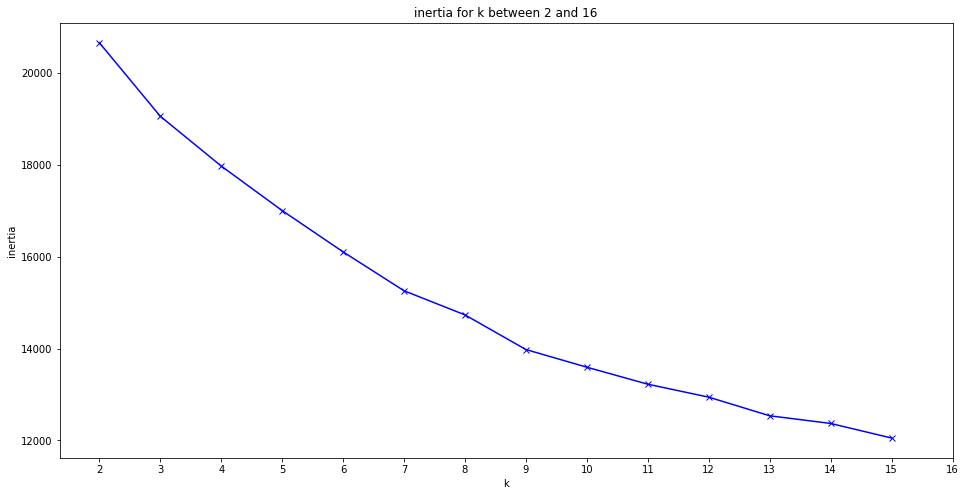

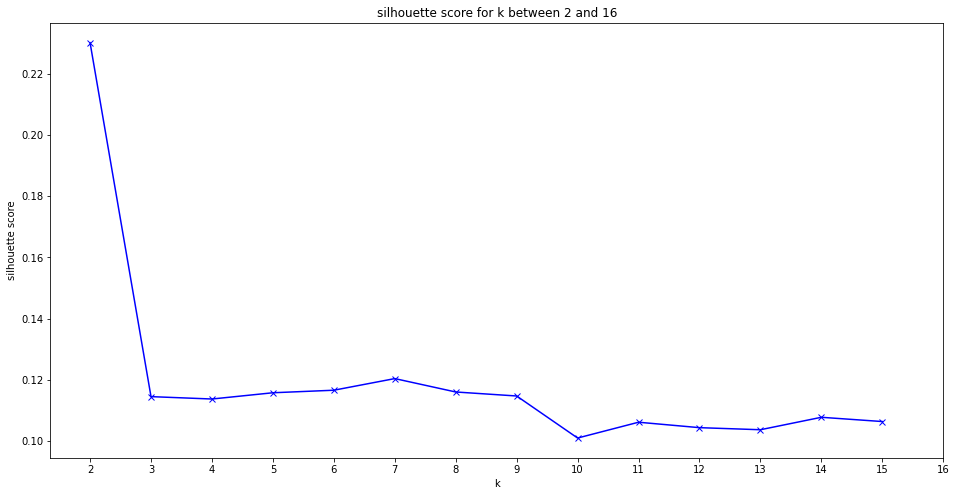

In [224]:
k_scores = kmeans_k_tuning(X_scaled, 2, 16)

### KMeans Clustering

In [225]:
# KMeans Clustering
kmeans = KMeans(n_clusters=9, random_state=88)
kmeans.fit(X_scaled)

# checking cluster size
clusters = kmeans.predict(X_scaled)
pd.Series(clusters).value_counts().sort_index()


0    116
1    195
2     78
3    253
4    382
5    407
6    187
7    161
8     79
dtype: int64

In [226]:
# adding cluster assignments to dataframe
hot100_clustered = hot100_audio_features.copy()
hot100_clustered["cluster"] = clusters

In [227]:
hot100_clustered.head()

,track_id,track_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,cluster
0,5HCyWlXZPP0y6Gqq8TgA20,STAY (with Justin Bieber),0.591,0.764,1.0,-5.484,1.0,0.0483,0.0383,0.0,0.103,0.478,169.928,141806.0,4.0,3
1,4kux0P5UfguojB4h0lQnsj,STAY (with Justin Bieber),0.587,0.795,1.0,-5.557,1.0,0.0522,0.0370,0.0,0.103,0.476,169.951,141806.0,4.0,3
2,2WYs5LxOZfEyURXu7V0O1a,Stay With Me,0.684,0.844,9.0,-7.649,1.0,0.3350,0.3020,0.0,0.374,0.335,126.677,141505.0,5.0,1
3,5PjdY0CKGZdEuoNab3yDmX,STAY (with Justin Bieber),0.591,0.764,1.0,-5.484,1.0,0.0483,0.0383,0.0,0.103,0.478,169.928,141806.0,4.0,3
4,6uBhi9gBXWjanegOb2Phh0,Stay,0.690,0.622,5.0,-5.025,0.0,0.0622,0.2530,0.0,0.116,0.544,102.040,210091.0,4.0,4


### Song recomendation

In [246]:
# finding song inside the same cluster after KMeans clustering returning 'similar' song 
# or predicting cluster if input song not yet in cluster df 
# inputs: df with songs, column with titles, column with clusters, outputs: df with similar song or new song 

def find_track_in_same_cluster(df, titles, clusters, transformer):
    # user input
    song_match = hot100_song_select()
    
    # case: song in input df
    if song_match in df[titles].values:
        for song in df[titles]:
            cluster_target = df[df[titles] == song_match][clusters].values[0]
            
        df_target_cluster = df[df[clusters] == cluster_target]
        df_target_cluster = df_target_cluster[df_target_cluster[titles] != song_match]
        df_target = df_target_cluster.sample(1)
        print('We picked a song you might also like.')
    
    # case: song not in input df   
    else:
        df_match = pd.DataFrame({'songs': [song_match]})
        df_match_ids = search_spotify_track_ids_list(df=df_match, tracks='songs')
        df_match_features = track_audio_features_to_df(df=df_match_ids, tracks='track_id').sample(1)
        df_target = predict_song_cluster(df=df_match_features, transformer=transformer, drop_col=['track_name', 'track_id'])
        df_target = pd.concat([df_match_features, df_target], axis=1)
        print('We are adding the song to our recommendation system so next time you ask for a sugesstion we have something for you.')
        
    return df_target


In [247]:
# assigns cluster to a song 

def predict_song_cluster(df, transformer, drop_col=[]):
    X_pred = df.copy()
    if drop_col != []:
        X_pred = X_pred.drop(drop_col, axis=1)
    # transform song data
    data_pred_scaled = transformer.transform(X_pred)
    X_pred_scaled = pd.DataFrame(data_pred_scaled)
    # cluster assignment
    clusters_pred = kmeans.predict(X_pred_scaled)
    X_pred["cluster"] = clusters_pred
    return X_pred

In [231]:
similar_song1 = find_track_in_same_cluster(df=hot100_clustered, titles='track_name', clusters='cluster', transformer=scaler)

What song do you like?  Bad Habits
Did you mean Bad Habits by Ed Sheeran?  yes


We picked a song you might also like.


In [232]:
similar_song1

,track_id,track_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,cluster
1595,6MDo7sy44456lULRdSDM80,Nevada,0.57,0.892,11.0,-3.471,0.0,0.0509,0.0183,0.000012,0.108,0.301,127.052,186213.0,4.0,4


In [248]:
similar_song2 = find_track_in_same_cluster(df=hot100_clustered, titles='track_name', clusters='cluster', transformer=scaler)

What song do you like?  Christmas


Your song is not in the Hot 100.
We are adding the song to our recommendation system so next time you ask for a sugesstion we have something for you.


In [249]:
similar_song2

,track_id,track_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,cluster
5,40gk32E7YaTFoQwDIWv2SY,Christmas Kids,0.425,0.754,2,-6.028,1,0.0367,0.0104,0.112,0.438,0.558,152.092,135693,4,0.425,0.754,2,-6.028,1,0.0367,0.0104,0.112,0.438,0.558,152.092,135693,4,3


### Updating Cluster data

In [ ]:
hot100_clustered = hot100_clustered.append(similar_song2, ignore_index=True)
hot100_clustered.tail()

# NOT WORKING - indexing